In [1]:
import argparse
from random import seed
from mylib.utils import fix_seed
from mylib.data.data_loader import load_ucidata
import collections
import numpy as np
from run_dnl import run_dnl
import tools
import pandas as pd
from kmeans import run_kmeans
import os
import argparse
import scipy
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import collections
# adjust the load data function to load training data only
from mylib.data.data_loader.load_ucidata import load_ucidata2


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import accuracy_score
from cal_acc import *
from scipy.optimize import linear_sum_assignment
from sklearn.decomposition import PCA
import SPICE
from mylib.data.dataset.util import noisify_multiclass_symmetric

from mylib.data.data_loader.subset import Dataset


/bin/bash: cd..: command not found


In [2]:
def _hungarian_match(flat_preds, flat_targets):
    # Based on implementation from IIC
    num_samples = flat_targets.shape[0]
    v, counts = np.unique(flat_preds, return_counts=True)

    num_k = len(v)
    num_correct = np.zeros((num_k, num_k))

    for c1 in range(num_k):
        for c2 in range(num_k):
            # elementwise, so each sample contributes once
            votes = int(((flat_preds == c1) * (flat_targets == c2)).sum())
            num_correct[c1, c2] = votes

    row, col = linear_sum_assignment(num_samples - num_correct)
    return row, col


def get_prime_Y(noisy_classes, pred_classes, mappings):
    prime_Y = np.zeros(len(noisy_classes))
    for i in range(len(pred_classes)):
        prime_Y[i] = mappings[pred_classes[i]]

    return prime_Y


def count_m(noisy_Y, prime_Y):
    values, counts = np.unique(prime_Y, return_counts=True)
    # print(values)
    length = len(values)
    m = np.zeros((length, length))
    # print(counts)

    for i in range(noisy_Y.shape[0]):
        m[int(prime_Y[i])][int(noisy_Y[i])] += 1

    sum_matrix = np.tile(counts, (len(values), 1)).transpose()
    # print(sum_matrix)
    # print(m/sum_matrix)
    return m/sum_matrix

# define K-means clustering algorithm


def run_kmeans2(dataset):

    X = dataset.data
    clean_Y = dataset.clean_targets
    tilde_Y = dataset.targets
    values, counts = np.unique(clean_Y, return_counts=True)

    kmeans = KMeans(n_clusters=len(values))
    kmeans.fit(X, tilde_Y)
    identified_clusters = kmeans.fit_predict(X)

    # note that to better match the cluster Id to tilde_Y,
    # we could use hat_clean Y which obtained by current noise-robust method, but for the simple dataset , it may not necessary

    idx2 = _hungarian_match(identified_clusters, tilde_Y)
    prime_Y = get_prime_Y(tilde_Y, identified_clusters, idx2[1])
    # yz: directly return prime_Y without using count_m
    return prime_Y



# --- parsing and configuration --- #
parser = argparse.ArgumentParser(
    description="PyTorch implementation of VAE")
parser.add_argument('--batch_size', type=int, default=16,
                    help='batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=10,
                    help='number of epochs to train (default: 20)')
parser.add_argument('--z_dim', type=int, default=25,
                    help='dimension of hidden variable Z (default: 10)')
parser.add_argument('--num_hidden_layers', type=int, default=2,
                    help='num hidden_layers (default: 0)')
parser.add_argument('--flip_rate_fixed', type=float,
                    help='fixed flip rates.', default=0.4)
parser.add_argument('--train_frac', default=1.0, type=float,
                    help='training sample size fraction')
parser.add_argument('--noise_type', type=str, default='sym')
parser.add_argument('--trainval_split',  default=0.8, type=float,
                    help='training set ratio')
parser.add_argument('--seed', default=1, type=int,
                    help='seed for initializing training')
parser.add_argument('--dataset', default="krkp", type=str,
                    help='db')
parser.add_argument('--select_ratio', default=0, type=float,
                    help='confidence example selection ratio')
parser.add_argument('--pretrained', default=0, type=int,
                    help='using pretrained model or not')


# added by yz:
# parser.add_argument('--pca_k', type=int, default=5,
#                     help='PCA dimension (default: 5)')
# parser.add_argument('--sample_size', type=int, default=20,
#                     help='randomly select samples for analysis')
# parser.add_argument('--near_percentage', type=float, default=0.1,
#                     help='percentage nearby in terms of L2 norm')
'''
Backbone Net Configurations
'''
parser.add_argument('--net', type=str, default='WideResNet')
parser.add_argument('--net_from_name', type=bool, default=False)
parser.add_argument('--depth', type=int, default=28)
parser.add_argument('--widen_factor', type=int, default=2)
parser.add_argument('--leaky_slope', type=float, default=0.1)
parser.add_argument('--dropout', type=float, default=0.0)



arch_dict = {"FashionMNIST": "resnet18", "cifar10": "resnet18", "cifar100": "resnet34", "mnist": "Lenet",
             "balancescale": "NaiveNet", "krkp": "NaiveNet", "splice": "NaiveNet", "yxguassian": "NaiveNet"}


In [3]:
### test cifar10n

cifar10n=torch.load('cifar-10-100n/data/CIFAR-100_human.pt')

cifar10n

{'clean_label': array([19, 29,  0, ...,  3,  7, 73]),
 'noisy_label': array([19, 63, 10, ..., 64, 24, 95]),
 'noisy_coarse_label': array([14, 12, 18, ..., 12,  7,  4]),
 'clean_coarse_label': array([14, 15,  4, ..., 18,  7,  1])}

In [4]:

# load dataset

from mylib.data.data_loader.load_cifardata import load_cifardata


args = parser.parse_args(args=["--dataset","cifar10"])
base_dir = "./"+args.dataset+"/"+args.noise_type + \
    str(args.flip_rate_fixed)+"/"+str(args.seed)+"/"
print(args)
if args.dataset == "cifar10":
    if args.seed is not None:
        fix_seed(args.seed)
        train_val_loader, train_loader, val_loader, est_loader, test_loader = load_cifardata(
            dataset=args.dataset, 
            random_state=args.seed,
            add_noise=True,
            batch_size=args.batch_size, 
            train_frac=args.train_frac, 
            trainval_split=args.trainval_split, 
            noise_type=args.noise_type, 
            flip_rate_fixed=args.flip_rate_fixed, 
            augment=False
        )
elif args.dataset == "":
    pass
else:
    if args.seed is not None:
        fix_seed(args.seed)
        train_val_loader, train_loader, val_loader, est_loader, test_loader = load_ucidata(
        dataset=args.dataset,
        noise_type=args.noise_type,
        random_state=args.seed,
        batch_size=args.batch_size,
        add_noise=True,
        flip_rate_fixed=args.flip_rate_fixed,
        trainval_split=args.trainval_split,
        train_frac=args.train_frac,
        augment=False
    )
# test_dataset = test_loader.dataset
val_dataset = val_loader.dataset
train_val_dataset = train_val_loader.dataset
train_dataset = train_loader.dataset
#print("training set length is: "+str(len(train_dataset.dataset.data)))
print("done")


Namespace(batch_size=16, epochs=10, z_dim=25, num_hidden_layers=2, flip_rate_fixed=0.4, train_frac=1.0, noise_type='sym', trainval_split=0.8, seed=1, dataset='cifar10', select_ratio=0, pretrained=0, net='WideResNet', net_from_name=False, depth=28, widen_factor=2, leaky_slope=0.1, dropout=0.0)
=> preparing data..
Files already downloaded and verified
Files already downloaded and verified
done


In [5]:
train_dataset.dataset.data.shape
#train_dataset.dataset.targets.shape

(50000, 32, 32, 3)

In [14]:
from mylib.data.data_loader.subset import Dataset
class BasicDataset(Dataset):
    """
    BasicDataset returns a pair of image and labels (targets).
    If targets are not given, BasicDataset returns None as the label.
    This class supports strong augmentation for Fixmatch,
    and return both weakly and strongly augmented images.
    """
    def __init__(self,
                 data,
                 targets=None,
                 num_classes=None,
                 transform=None,
                 use_strong_transform=False,
                 strong_transform=None,
                 onehot=False,
                 *args, **kwargs):
        """
        Args
            data: x_data
            targets: y_data (if not exist, None)
            num_classes: number of label classes
            transform: basic transformation of data
            use_strong_transform: If True, this dataset returns both weakly and strongly augmented images.
            strong_transform: list of transformation functions for strong augmentation
            onehot: If True, label is converted into onehot vector.
        """
        super(BasicDataset, self).__init__()
        self.data = data
        self.targets = targets
        
        self.num_classes = num_classes
        self.use_strong_transform = use_strong_transform
        self.onehot = onehot
        
        self.transform = transform
        if use_strong_transform:
            pass
        else:
            self.strong_transform = strong_transform
                

In [7]:


from torchvision import datasets, transforms
from torch.utils.data import sampler, DataLoader
mean, std = {}, {}
mean['cifar10'] = [x / 255 for x in [125.3, 123.0, 113.9]]
mean['cifar100'] = [x / 255 for x in [129.3, 124.1, 112.4]]
mean['stl10'] = [0.485, 0.456, 0.406]
mean['npy'] = [0.485, 0.456, 0.406]
mean['npy224'] = [0.485, 0.456, 0.406]

std['cifar10'] = [x / 255 for x in [63.0, 62.1, 66.7]]
std['cifar100'] = [x / 255 for x in [68.2,  65.4,  70.4]]
std['stl10'] = [0.229, 0.224, 0.225]
std['npy'] = [0.229, 0.224, 0.225]
std['npy224'] = [0.229, 0.224, 0.225]


def get_dset(data,targets, num_classes, name, train, use_strong_transform=False, 
                strong_transform=None, onehot=False):
    """
    get_dset returns class BasicDataset, containing the returns of get_data.
    
    Args
        use_strong_tranform: If True, returned dataset generates a pair of weak and strong augmented images.
        strong_transform: list of strong_transform (augmentation) if use_strong_transform is True
        onehot: If True, the label is not integer, but one-hot vector.
    """
    
    transform = get_transform(mean[name], std[name], name, train)
    
    return BasicDataset(data, targets, num_classes, transform, 
                        use_strong_transform, strong_transform, onehot)
    


    
def get_transform(mean, std, dataset, train=True):
    if dataset in ['cifar10', 'cifar20', 'cifar100']:
        crop_size = 32
    elif dataset in ['stl10', 'npy']:
        crop_size = 96
    elif dataset in ['npy224']:
        crop_size = 224
    else:
        raise TypeError
    if train:
        return transforms.Compose([transforms.RandomHorizontalFlip(),
                                    transforms.RandomCrop(crop_size, padding=4),
                                    transforms.ToTensor(), 
                                    transforms.Normalize(mean, std)])
    else:
        return transforms.Compose([transforms.ToTensor(), 
                                    transforms.Normalize(mean, std)])
        
def get_data_loader(dset,
                    batch_size = None,
                    shuffle = False,
                    num_workers = 4,
                    pin_memory = True,
                    data_sampler = None,
                    replacement = True,
                    num_epochs = None,
                    num_iters = None,
                    generator = None,
                    drop_last=True,
                    distributed=False):
    """
    get_data_loader returns torch.utils.data.DataLoader for a Dataset.
    All arguments are comparable with those of pytorch DataLoader.
    However, if distributed, DistributedProxySampler, which is a wrapper of data_sampler, is used.
    
    Args
        num_epochs: total batch -> (# of batches in dset) * num_epochs 
        num_iters: total batch -> num_iters
    """
    
    assert batch_size is not None
        
    if data_sampler is None:
        return DataLoader(dset, batch_size=batch_size, shuffle=shuffle, 
                          num_workers=num_workers, pin_memory=pin_memory)
    
    # else:
    #     if isinstance(data_sampler, str):
    #         data_sampler = get_sampler_by_name(data_sampler)
        
    #     if distributed:
    #         assert dist.is_available()
    #         num_replicas = dist.get_world_size()
    #     else:
    #         num_replicas = 1
        
    #     if (num_epochs is not None) and (num_iters is None):
    #         num_samples = len(dset)*num_epochs
    #     elif (num_epochs is None) and (num_iters is not None):
    #         num_samples = batch_size * num_iters * num_replicas
    #     else:
    #         num_samples = len(dset)
        
    #     if data_sampler.__name__ == 'RandomSampler':    
    #         data_sampler = data_sampler(dset, replacement, num_samples, generator)
    #     else:
    #         raise RuntimeError(f"{data_sampler.__name__} is not implemented.")
        
    #     if distributed:
    #         '''
    #         Different with DistributedSampler, 
    #         the DistribuedProxySampler does not shuffle the data (just wrapper for dist).
    #         '''
    #         data_sampler = DistributedProxySampler(data_sampler)

    #     batch_sampler = BatchSampler(data_sampler, batch_size, drop_last)
    #     return DataLoader(dset, batch_sampler=batch_sampler, 
    #                       num_workers=num_workers, pin_memory=pin_memory)

    

In [15]:
my_data_dest = get_dset(train_dataset.dataset.data,train_dataset.dataset.targets,10,"cifar10",True)

my_data_loader=get_data_loader(my_data_dest,batch_size=args.batch_size,num_workers=1)


# my_data_loader = train_val_loader


In [10]:
my_data_loader.dataset.data.shape

(50000, 32, 32, 3)

In [16]:
load_model = torch.load('model_cifar10_cls.pth',map_location=torch.device('cpu'))

from fixmatch.utils import *
_net_builder = net_builder(args.net,
                                   args.net_from_name,
                                   {'depth': args.depth,
                                    'widen_factor': args.widen_factor,
                                    'leaky_slope': args.leaky_slope,
                                    'dropRate': args.dropout})

net = _net_builder(num_classes=10)
net.load_state_dict(load_model,strict=False)

net.eval()

depth in <fixmatch.models.nets.wrn.build_WideResNet object at 0x16764fe80> is overlapped by kwargs: 28 -> 28
widen_factor in <fixmatch.models.nets.wrn.build_WideResNet object at 0x16764fe80> is overlapped by kwargs: 2 -> 2
leaky_slope in <fixmatch.models.nets.wrn.build_WideResNet object at 0x16764fe80> is overlapped by kwargs: 0.0 -> 0.1
dropRate in <fixmatch.models.nets.wrn.build_WideResNet object at 0x16764fe80> is overlapped by kwargs: 0.0 -> 0.0


WideResNet(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
  (block1): NetworkBlock(
    (layer): Sequential(
      (0): BasicBlock(
        (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv1): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (relu2): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (convShortcut): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
      )
      (1): BasicBlock(
        (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.01, affine=True, track_running_stats=True)
        (relu1): LeakyReLU(negative_slope=0.1, inplace=True)
        (conv1): Conv2d(32, 32, kernel_size=(3, 

In [17]:

def calculate_acc(ypred, y, return_idx=False):
    """
    Calculating the clustering accuracy. The predicted result must have the same number of clusters as the ground truth.

    ypred: 1-D numpy vector, predicted labels
    y: 1-D numpy vector, ground truth
    The problem of finding the best permutation to calculate the clustering accuracy is a linear assignment problem.
    This function construct a N-by-N cost matrix, then pass it to scipy.optimize.linear_sum_assignment to solve the assignment problem.

    """
    assert len(y) > 0
    assert len(np.unique(ypred)) == len(np.unique(y))

    s = np.unique(ypred)
    t = np.unique(y)

    N = len(np.unique(ypred))
    C = np.zeros((N, N), dtype=np.int32)
    for i in range(N):
        for j in range(N):
            idx = np.logical_and(ypred == s[i], y == t[j])
            C[i][j] = np.count_nonzero(idx)

    # convert the C matrix to the 'true' cost
    Cmax = np.amax(C)
    C = Cmax - C
    row, col = linear_sum_assignment(C)
    # calculating the accuracy according to the optimal assignment
    count = 0
    for i in range(N):
        idx = np.logical_and(ypred == s[row[i]], y == t[col[i]])
        count += np.count_nonzero(idx)

    if return_idx:
        return 1.0 * count / len(y), row, col
    else:
        return 1.0 * count / len(y)


In [19]:


acc = 0.0
labels_pred = []
labels_gt = []
scores = []
with torch.no_grad():
    for image, label in my_data_loader:
        #image = image.type(torch.FloatTensor).cuda()
        print("=====")
        logit = net(image)

        scores.append(logit.cpu().numpy())

        labels_pred.append(torch.max(logit, dim=-1)[1].cpu().numpy())
        labels_gt.append(label.cpu().numpy())

scores = np.concatenate(scores, axis=0)
labels_pred = np.concatenate(labels_pred, axis=0)
labels_gt = np.concatenate(labels_gt, axis=0)
# save labels added by yz
#np.save("labels_pred.npy", labels_pred)

try:
    acc = calculate_acc(labels_pred, labels_gt)
except:
    acc = -1

#nmi = calculate_nmi(labels_pred, labels_gt)
#ari = calculate_ari(labels_pred, labels_gt)

print(f"Test Accuracy: {acc}")   #, NMI: {nmi}, ARI: {ari}")

if args.scores_path is not None:
    np.save(args.scores_path, scores)

Traceback (most recent call last):
  File "<string>", line 1, in <module>
  File "/Users/yangz/miniforge3/envs/al/lib/python3.9/multiprocessing/spawn.py", line 116, in spawn_main
    exitcode = _main(fd, parent_sentinel)
  File "/Users/yangz/miniforge3/envs/al/lib/python3.9/multiprocessing/spawn.py", line 126, in _main
    self = reduction.pickle.load(from_parent)
AttributeError: Can't get attribute 'BasicDataset' on <module '__main__' (built-in)>


KeyboardInterrupt: 

In [ ]:
acc

-1

In [ ]:
idx2 = _hungarian_match(labels_pred, train_dataset.dataset.targets)
prime_Y = get_prime_Y(train_dataset.dataset.targets, labels_pred, idx2[1])

#train_loader.dataset.dataset.targets[0]
prime_Y

IndexError: index 7 is out of bounds for axis 0 with size 3

# Non-image dataset

In [ ]:
initial_noise_labels = train_dataset.dataset.targets
num_classes = train_dataset.dataset._get_num_classes()
primeY = run_kmeans2(train_dataset.dataset)

train_labels = initial_noise_labels.copy()
train_labels = train_labels[:,np.newaxis]

error_list = []
noise_list = np.arange(0.1, 1, 0.1)
for noise_rate in noise_list:
    train_noisy_labels, _, _ = noisify_multiclass_symmetric(initial_noise_labels.copy()[:,np.newaxis], noise_rate, random_state=args.seed, nb_classes=num_classes)
    # sanity check on label noise rate
    # res1 = (initial_noise_labels == train_noisy_labels[:,0])
    # count1 = collections.Counter(res1)
    # label_noise_rate = count1[False]/(count1[False]+count1[True])
    # print("after adding noise, the noise rate is: "+str(label_noise_rate))
    
    # calcualte error rate on the noisy labels
    res2 = (primeY == train_noisy_labels[:,0])
    count2 = collections.Counter(res2)
    error_rate = count2[False]/(count2[False]+count2[True])
    print("compare with Y prime, error rate is : "+str(error_rate))
    error_list.append(error_rate)
    



compare with Y prime, error rate is : 0.642
compare with Y prime, error rate is : 0.608
compare with Y prime, error rate is : 0.63
compare with Y prime, error rate is : 0.664
compare with Y prime, error rate is : 0.664
compare with Y prime, error rate is : 0.664
compare with Y prime, error rate is : 0.646
compare with Y prime, error rate is : 0.666
compare with Y prime, error rate is : 0.664


(0.0, 1.0)

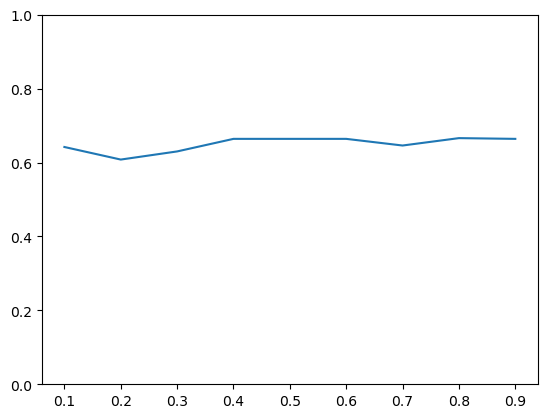

In [ ]:
%matplotlib inline
plt.plot(noise_list, error_list)
plt.ylim(0,1)


In [ ]:

# ---- Load data ---- #

noisy_data_list = []
noisy_rate_list = np.arange(0.1, 1, 0.2)

for rate in noisy_rate_list:
    train_loader = load_ucidata2(
        dataset=args.dataset,
        noise_type="sym",
        random_state=args.seed,
        batch_size=args.batch_size,
        add_noise=True,
        flip_rate_fixed=rate,
        trainval_split=args.trainval_split,
        train_frac=args.train_frac,
        augment=False
    )

    noisy_data_list.append(train_loader.dataset)

# primeY is obtained from K-means unsupervised learning -> we use this as esitmated Clean Y
primeY = run_kmeans2(train_dataset.dataset)

error_list = []
for i in range(len(noisy_data_list)):
    noisy_data = noisy_data_list[i]
    noisy_Y = noisy_data.dataset.targets
    res = (primeY == noisy_Y)
    count = collections.Counter(res)
    error_rate = count[False]/(count[False]+count[True])
    error_list.append(error_rate)

df = pd.concat([pd.DataFrame(noisy_rate_list),
                pd.DataFrame(error_list)], axis=1)
df.columns = ['noisy_rate', 'error_rate']

df['dataset'] = args.dataset

df['noise_type'] = args.noise_type
# if dataset in "krkp", "balancescale", "splice", "xyguassian" then it is causal
df['causal'] = df['dataset'].apply(
    lambda x: 1 if x in ["krkp", "balancescale", "splice", "xyguassian"] else 0)
df['inital_noise'] = args.flip_rate_fixed
df['seed'] = args.seed
df.to_csv('./results/results_method1_error_rate.csv',
            mode='a', index=False, header=False)

print("all done")


